# 3.


To improve user engagement on **BeerAdvocate**, we developed a system to map users to predefined beer clusters based on their preferences and see to which communities they belong to. Using data from beer reviews, we applied **Principal Component Analysis (PCA)** to the beer reviews text to reduce the dimensionality of the dataset and identify key beer characteristics of each clusters. With the 5 principal components (PCs), we saw that the key characteristics that describes a beer were present in those 5 Principal Components which captured distinctions such as "balanced beers vs. rich and complex beers" and "sour and tart beers vs. hop-forward beers." These PCs were used to define clusters that represent unique beer styles, such as IPAs, stouts, and lagers. We then crafted five user-friendly questions aligned with the PCs that we had to interpret, allowing users to express their preferences on a scale of **-1 to 1** for each question.


User responses are normalized and scaled to align with the PCA space of cluster centroids. By calculating the Euclidean distance between the user's position in PCA space and the centroids of each cluster, we assign the user to the nearest cluster. This system enhances BeerAdvocate's user experience by delivering tailored recommendations, enabling users to explore beer styles aligned with their tastes, and providing actionable insights into user preferences for platform improvement and targeted marketing. This interactive approach bridges the gap between user engagement and beer discovery, offering a personalized, data-driven experience. It also allows the user to find like-minded people who think like him but most importantly *drink* like him!

In [ ]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import swifter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from src.data.beerdata_loader import BeerDataLoader

#### Loading of the data

In [ ]:
data_loader = BeerDataLoader(data_dir="./data/", force_process=False)

ba_reviews_df, ba_ratings_df, ba_beers_df, ba_breweries_df, ba_users_df = data_loader.load_all_data()

Processed file './data/reviews_processed.csv' already exists. Skipping processing.
Processed file './data/ratings_processed.csv' already exists. Skipping processing.


#### Mapping each beer to the appropriate cluster (cluster from 0 to 8)

In [ ]:
partition_file = "data/partition.json"
with open(partition_file, "r") as f:
    partition = json.load(f)

# Map beer_id to cluster
beer_cluster_map = {int(k): v for k, v in partition.items()}
# Add cluster information to beers
ba_beers_df["cluster"] = ba_beers_df["beer_id"].map(beer_cluster_map)

# Filter reviews to only those beers in the cluster map
ba_reviews_df = ba_reviews_df[ba_reviews_df["beer_id"].isin(beer_cluster_map.keys())]

# Drop rows without text and ensure text is a string
ba_reviews_df = ba_reviews_df.dropna(subset=["text"])
ba_reviews_df["text"] = ba_reviews_df["text"].astype(str)

#### Combining the reviews by beer and aggregating the reviews each beer got

In this step, we combine all the reviews for each beer into a single text entry. This allows us to analyze the overall sentiment and characteristics of each beer based on all its reviews. We then merge this aggregated review data with the cluster information for each beer, ensuring that each beer is assigned to the correct cluster. Finally, we convert the cluster information to a categorical data type for more efficient processing.


In [ ]:
beer_texts = (
    ba_reviews_df.groupby("beer_id")["text"]
    .agg(' '.join)
    .reset_index()
)

# Merge with cluster information
beer_texts = beer_texts.merge(ba_beers_df[["beer_id", "cluster"]], on="beer_id", how="left")
beer_texts = beer_texts.dropna(subset=["cluster"])

# Convert cluster to category for efficiency
beer_texts["cluster"] = beer_texts["cluster"].astype("category")

#### Looking at the distribution of cluster 0-8

In [63]:
# -------------------------
# Keep only the first 9 clusters (0 through 8)
# -------------------------
clusters_to_keep = list(range(9))
beer_texts = beer_texts[beer_texts["cluster"].isin(clusters_to_keep)]

# IMPORTANT: Remove unused categories after filtering
beer_texts["cluster"] = beer_texts["cluster"].cat.remove_unused_categories()

# Verify distribution again after filtering
print("\nDistribution of beers by cluster after filtering (0-8):")
cluster_counts_filtered = beer_texts["cluster"].value_counts().sort_index()
total_beers_filtered = cluster_counts_filtered.sum()
cumulative = 0
for cl, count in cluster_counts_filtered.items():
    cumulative += count
    cum_pct = (cumulative / total_beers_filtered) * 100
    print(f"Cluster {cl}: {count} beers, cumulative %: {cum_pct:.2f}%")


Distribution of beers by cluster after filtering (0-8):
Cluster 0.0: 21575 beers, cumulative %: 16.46%
Cluster 1.0: 4323 beers, cumulative %: 19.76%
Cluster 2.0: 18464 beers, cumulative %: 33.85%
Cluster 3.0: 19754 beers, cumulative %: 48.92%
Cluster 4.0: 15250 beers, cumulative %: 60.56%
Cluster 5.0: 24507 beers, cumulative %: 79.26%
Cluster 6.0: 15632 beers, cumulative %: 91.18%
Cluster 7.0: 9933 beers, cumulative %: 98.76%
Cluster 8.0: 1623 beers, cumulative %: 100.00%


#### Text cleaning

Now that we have the joined each raw review for each beer. We now need to clean that text. In order to do this, it is important to keep in mind that our goal is to cluster the beer reviews. Therefore, there will be many words that will render useless. We filtered the most meaningful words in `extract_beer_lexicon.ipynb`. Essentially, we did basic text cleaning (removed stopwords, lemmatized), then, created a TF-IDF matrix, looked at the 1000 most meaningful words and then picked the words that are used to describe beer's aroma, flavour taste and general sentiment.

In [ ]:
# extracted from extract_beer_lexicon.ipynb
beer_lexicon = {
    'beer', 'ale', 'lager', 'stout', 'porter', 'pilsner', 'ipa', 'brewer', 
 'brewery', 'brewing', 'draft', 'cask', 'bottle', 'glass', 'pour', 'tap','head', 'foam', 
    'frothy', 'bubbly', 'carbonated', 'flat', 'clarity','hazy', 'opaque', 'cloudy', 'clear', 'golden', 'amber', 'brown', 'dark', 
 'black', 'mahogany', 'ruby', 'white', 'pale', 'yellow', 'beige', 'red', 
 'floral', 'herbal', 'earthy', 'spicy', 'citrusy', 'fruity', 'sweet', 
 'sour', 'bitter', 'bitterness', 'smooth', 'rich', 'dry', 'crisp', 'creamy', 
 'sticky', 'tart', 'tangy', 'sweetness', 'malty', 'hoppy', 'aromatic', 
 'aroma', 'aftertaste', 'subtle', 'intense',
'barley', 'malt', 'malty', 'grain', 'yeast', 'hops', 'hop', 'water', 
 'spices', 'vanilla', 'chocolate', 'caramel', 'toffee', 'coffee', 'cocoa', 
 'citrus', 'orange', 'lemon', 'grapefruit', 'pine', 'oak', 'nutty', 'raisin', 
 'plum', 'cherry', 'maple', 'banana', 'berry', 'ginger','session', 'sessionable', 'pint', 'ounce', 'ounce', 'snifter', 'chalice', 
 'pub', 'bar', 'draught', 'taste', 'drink', 'drinker', 'sip', 'gulp', 
 'quaffable','balanced', 'strong', 'bold', 'weak', 'delicate', 'refreshing', 'complex', 
 'light', 'heavy', 'moderate', 'intense', 'robust', 'unique', 'classic', 
 'distinctive', 'remarkable', 'awesome', 'excellent', 'superb', 'good', 
 'decent', 'ok', 'average', 'bad', 'boring', 'cheap', 'quality','balanced', 'strong', 'bold', 'weak', 'delicate', 'refreshing', 'complex', 
 'light', 'heavy', 'moderate', 'intense', 'robust', 'unique', 'classic', 
 'distinctive', 'remarkable', 'awesome', 'excellent', 'superb', 'good', 
 'decent', 'ok', 'average', 'bad', 'boring', 'cheap', 'aged', 'vintage', 'cellar', 'oak', 'barrel', 'reserve', 'craft', 'microbrewery', 'homebrew', 'regional', 'seasonal', 'festive', 
 'holiday', 'celebration', 'festival', 'special'}


# for a review just keep the words that are in the beer lexicon
def clean_text_lexicon(text):
    text = text.lower()
    cleaned_text = [word for word in text.split() if word in beer_lexicon]
    return " ".join(cleaned_text)

# Parallel cleaning
beer_texts["clean_text"] = beer_texts["text"].swifter.apply(clean_text_lexicon)

Pandas Apply:   0%|          | 0/131061 [00:00<?, ?it/s]

#### Creation of the TF-IDF matrix from the beer lexicon

In [ ]:
vectorizer = TfidfVectorizer(
    #stop_words="english",
    max_features=1000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.5
)

X = vectorizer.fit_transform(beer_texts["clean_text"])

### PCA Explanation

 `n_components` is set to 5. After trying many different options of numbe of PCs we came to the concusion that using 5 PCs was enough to describe fully each cluster and that there was enough variation in those Principal Components to ask the necessary question to lead a user to its corresponding cluster.


In [ ]:
n_components = 5
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_pca = svd.fit_transform(X)

# Attach PCA components back to DataFrame
for i in range(n_components):
    beer_texts[f"PC{i+1}"] = X_pca[:, i]

This code performs an ANOVA test to check for differences across clusters for each principal component (PC) obtained from PCA. It iterates through each PC, groups the data by clusters, and ensures no groups are empty before performing the ANOVA test. The F-statistic and p-value are printed for each PC. If any group is empty, it prints a message indicating that ANOVA cannot be computed. Finally, it prints the explained variance ratio for each PC and the cumulative explained variance.

In [20]:
from scipy.stats import f_oneway

# -------------------------
# ANOVA to check differences across clusters for each PC
# -------------------------
for i in range(n_components):
    pc_col = f"PC{i+1}"
    # Ensure no empty groups:
    groups = [group[pc_col].values for _, group in beer_texts.groupby("cluster")]
    # ANOVA requires that each group has data
    if all(len(g) > 0 for g in groups):
        stat, p = f_oneway(*groups)
        print(f"ANOVA for {pc_col}: F={stat:.2f}, p={p:.3e}")
    else:
        print(f"ANOVA for {pc_col}: Unable to compute (empty group).")

# Print explained variance ratios
print("\nExplained variance ratio per PC:", svd.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(svd.explained_variance_ratio_))

ANOVA for PC1: F=3449.37, p=0.000e+00
ANOVA for PC2: F=33800.90, p=0.000e+00
ANOVA for PC3: F=13588.34, p=0.000e+00
ANOVA for PC4: F=12246.45, p=0.000e+00
ANOVA for PC5: F=8026.00, p=0.000e+00

Explained variance ratio per PC: [0.02883866 0.04587999 0.02062848 0.01751582 0.01431831]
Cumulative explained variance: [0.02883866 0.07471865 0.09534713 0.11286295 0.12718126]


### Inspecting Top Terms for each PC

This part is very important because from the top term for each PC we need to then interpret what this principal components actually means and what information and variation in the data the PC vehiculates. 

This will be further very useful because by interprating each PC well we can then ask the question that best corresponds to the information that is being encapsulated. Based on the answer corresponding to each PC the user gives, we will then find the nearest corresponding cluster. Which is why the interpretation of a PCs is very important if we want those resuls to be useful.

In [21]:
# -------------------------
# Inspecting Top Terms for Each PC
# -------------------------
terms = np.array(vectorizer.get_feature_names_out())

for i in range(n_components):
    comp = svd.components_[i]
    sorted_idx = np.argsort(comp)[::-1]
    top_positive_terms = terms[sorted_idx[:20]]
    top_negative_terms = terms[sorted_idx[-20:]]
    print(f"\nPrincipal Component {i+1} Interpretation")
    print("Top positively contributing terms:", top_positive_terms)
    print("Top negatively contributing terms:", top_negative_terms)


Principal Component 1 Interpretation
Top positively contributing terms: ['malt' 'sweet' 'hop' 'white' 'dark' 'hops' 'taste' 'citrus' 'brown'
 'caramel' 'aroma' 'orange' 'bottle' 'bitter' 'bitterness' 'golden' 'pale'
 'amber' 'dry' 'white head']
Top negatively contributing terms: ['head bottle' 'drink drink' 'vanilla dark' 'good coffee'
 'bitterness bottle' 'chocolate sweetness' 'brown coffee' 'smooth bottle'
 'chocolate black' 'beer sip' 'rich chocolate' 'chocolate bitterness'
 'stout black' 'strong coffee' 'bottle snifter' 'pint black'
 'coffee stout' 'coffee vanilla' 'coffee smooth' 'coffee black']

Principal Component 2 Interpretation
Top positively contributing terms: ['dark' 'chocolate' 'coffee' 'brown' 'black' 'dark brown' 'stout'
 'vanilla' 'barrel' 'dark chocolate' 'cocoa' 'brown head' 'porter' 'rich'
 'creamy' 'oak' 'dark dark' 'black head' 'beer dark' 'aged']
Top negatively contributing terms: ['yeast' 'yellow white' 'golden white' 'hoppy' 'crisp' 'clear' 'pine'
 'grapefruit

#### Cluster Means for Each PC

We now compute the mean of each cluster based on the PCA we previously did. This will be helpful later in order to tell user to which cluster they belong to.

In [ ]:
cluster_means = beer_texts.groupby("cluster")[[f"PC{i+1}" for i in range(n_components)]].mean()
print("\nMean principal component scores by cluster (0-8):")
print(cluster_means)


Mean principal component scores by cluster (0-8):
              PC1       PC2       PC3       PC4       PC5
cluster                                                  
0.0      0.302240 -0.113818  0.027190  0.016874 -0.102487
1.0      0.272879  0.239363  0.078421 -0.042309  0.074282
2.0      0.438018 -0.169051 -0.119701  0.055911  0.088201
3.0      0.294339  0.333285 -0.010617  0.127732 -0.020896
4.0      0.306248 -0.110408  0.120383  0.036100 -0.001810
5.0      0.330678  0.091975 -0.033730 -0.135257 -0.010654
6.0      0.189145 -0.036239 -0.011842  0.015151  0.007993
7.0      0.247456 -0.020370  0.238165 -0.046405  0.121023
8.0      0.287911 -0.057828  0.054868 -0.029566 -0.052702


In [1]:
cluster_means = {
    0: [0.302240, -0.113818,  0.027190,  0.016874, -0.102487],
    1: [0.272879,  0.239363,  0.078421, -0.042309,  0.074282],
    2: [0.438018, -0.169051, -0.119701,  0.055911,  0.088201],
    3: [0.294339,  0.333285, -0.010617,  0.127732, -0.020896],
    4: [0.306248, -0.110408,  0.120383,  0.036100, -0.001810],
    5: [0.330678,  0.091975, -0.033730, -0.135257, -0.010654],
    6: [0.189145, -0.036239, -0.011842,  0.015151,  0.007993],
    7: [0.247456, -0.020370,  0.238165, -0.046405,  0.121023],
    8: [0.287911, -0.057828,  0.054868, -0.029566, -0.052702]
}

This code normalizes cluster mean values using z-score normalization and then scales them to the range [-1, 1]. It sets up labels and mappings for different beer clusters and principal components (PCs). A function is defined to create radar charts (spider charts) that visualize the normalized means for each cluster. The radar chart is plotted with aesthetic adjustments, showing the normalized data for each cluster with different colors. Finally, the function is called to display the radar chart.

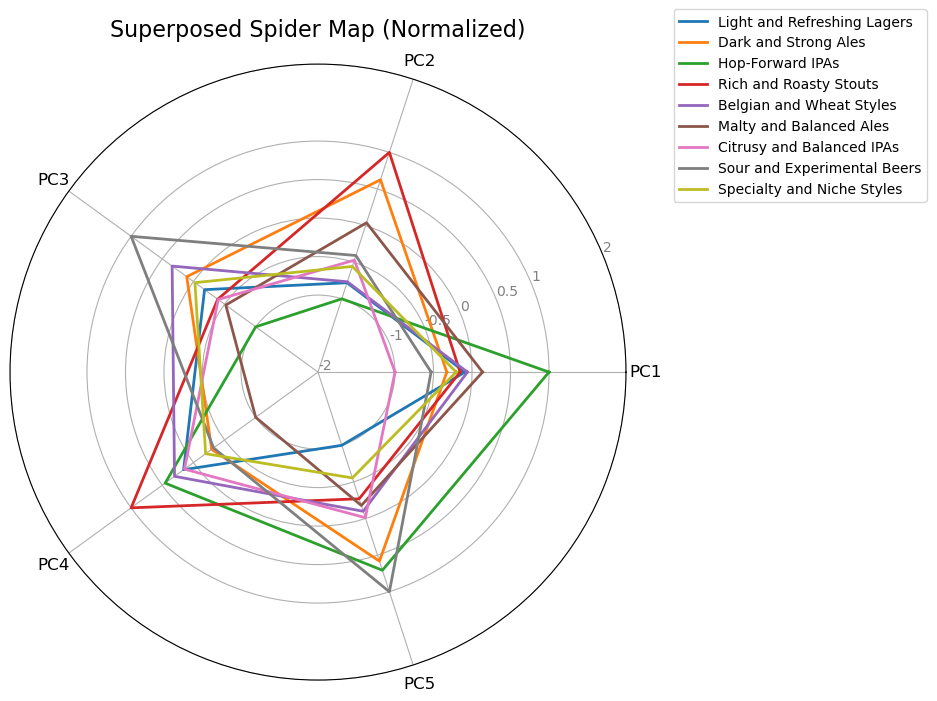

In [3]:
from sklearn.preprocessing import StandardScaler

# Normalize the data using Min-Max scaling (to range between 0 and 1)
# Normalize the data using Min-Max scaling (to range between 0 and 1)
# Standard Scaling (z-score normalization)
scaler = StandardScaler()
normalized_means = scaler.fit_transform(np.array(list(cluster_means.values())))

# Scale the normalized values to the range [-1, 1]
normalized_means = 2 * (normalized_means - np.min(normalized_means, axis=0)) / (np.max(normalized_means, axis=0) - np.min(normalized_means, axis=0)) - 1

# Radar chart setup
labels = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
num_vars = len(labels)

cluster_mapping = {
    0: 'Light and Refreshing Lagers',
    1: 'Dark and Strong Ales',
    2: 'Hop-Forward IPAs',
    3: 'Rich and Roasty Stouts',
    4: 'Belgian and Wheat Styles',
    5: 'Malty and Balanced Ales',
    6: 'Citrusy and Balanced IPAs',
    7: 'Sour and Experimental Beers',
    8: 'Specialty and Niche Styles'
}

pca_explanations = {
    "PC1": "Generic, flavor-focused beers vs. famous, specialty, or seasonal beers.",
    "PC2": "Dark, roasted stouts/porters vs. lighter, hoppier beers like pale ales/IPAs.",
    "PC3": "Hop-driven, bitter IPAs vs. sour, funky, fruity Belgian-style beers.",
    "PC4": "Complex, citrusy, and barrel-aged beers vs. simpler, grain-forward lagers/ales.",
    "PC5": "Lighter wheat or coffee-accented beers vs. richer, sweeter malt-heavy styles.",
    "PC6": "Subtle barrel-aged, vanilla/oak-influenced beers vs. spicy, Belgian/pumpkin beers.",
    "PC7": "Tart, funky, sour beers vs. spicy, wheat-driven Belgian styles.",
    "PC8": "Sensitivity to subtle mouthfeel and aroma vs. more straightforward style and flavor."
}

# Function to plot radar charts
def create_superposed_spider_chart(normalized_means):
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Colors for each cluster
    colors = plt.cm.tab10(np.linspace(0, 1, len(normalized_means)))

    # Plot each cluster
    for cluster_id, means in enumerate(normalized_means):
        data = means.tolist() + [means[0]]  # Close the circle
        ax.plot(angles, data, label=cluster_mapping[cluster_id], linewidth=2)
        #ax.fill(angles, data, alpha=0.1)

    # Aesthetic adjustments
    ax.set_yticks([-2, -1, -0.5, 0, 0.5, 1, 2])
    ax.set_yticklabels(['-2', '-1', '-0.5', '0', '0.5', '1', '2'], color="gray", size=10)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, size=12)

    ax.set_title("Superposed Spider Map (Normalized)", size=16, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1.1))
    plt.show()

# Call the function with normalized data
create_superposed_spider_chart(normalized_means)

# Principal Component Interpretations and Questions to ask to the user

### **Principal Component 1: Balanced Beers vs. Rich and Complex Beers**
- **Top positively contributing terms**: malt, sweet, hop, citrus, caramel, bitterness, amber, golden, white head.
- **Top negatively contributing terms**: coffee stout, chocolate sweetness, rich chocolate, coffee black, smooth bottle.

### **Interpretation**:  
This PC contrasts **balanced beers with malt, citrus, and hop-forward flavors** with **rich, complex beers** that emphasize chocolate, coffee, and smoothness (e.g., stouts and porters).

### **Question**:  
*"Do you prefer balanced beers with malt, citrus, and hop-forward flavors, or rich, complex beers with chocolate and coffee notes?"*

---

### **Principal Component 2: Dark, Roasted Beers vs. Light, Refreshing Beers**
- **Top positively contributing terms**: dark, chocolate, coffee, vanilla, barrel, stout, porter, rich, aged.
- **Top negatively contributing terms**: golden, crisp, grapefruit, hazy, floral, citrus, pale, hop, white.

### **Interpretation**:  
This PC contrasts **dark, roasted beers with rich flavors like chocolate and coffee** with **light and refreshing beers with crisp and citrus-forward profiles**.

### **Question**:  
*"Do you enjoy dark beers with roasted flavors like chocolate and coffee, or light, refreshing beers with crisp citrus notes?"*

---

### **Principal Component 3: Sour and Tart Beers vs. Hop-Forward Beers**
- **Top positively contributing terms**: sour, tart, yeast, banana, oak, golden, refreshing, sweet.
- **Top negatively contributing terms**: hops, pine, caramel malt, bitterness, amber, malt, citrus, hoppy.

### **Interpretation**:  
This PC contrasts **sour and tart beers** (e.g., Berliner Weisse, lambics) with **hop-forward beers** (e.g., IPAs and pale ales) featuring pine, citrus, and bitterness.

### **Question**:  
*"Do you prefer sour and tart beers with yeast-forward or fruity flavors, or hop-forward beers with pine, citrus, and bitterness?"*

---

### **Principal Component 4: Coffee and Chocolate Beers vs. Sweet and Malty Beers**
- **Top positively contributing terms**: coffee, chocolate, citrus, stout, grapefruit, bitter, pale, hop, hazy.
- **Top negatively contributing terms**: sweet caramel, caramel malt, toffee, oak, amber, red, malty, brown, sour.

### **Interpretation**:  
This PC contrasts **coffee and chocolate-forward beers** (e.g., stouts and porters) with **sweet, malty beers** (e.g., amber ales, red ales, or barrel-aged styles).

### **Question**:  
*"Do you prefer beers with coffee and chocolate flavors, or sweet, malty beers with caramel and toffee notes?"*

---

### **Principal Component 5: Tart and Fruity Beers vs. Light and Crisp Beers**
- **Top positively contributing terms**: orange, citrus, sour, tart, barrel, grapefruit, pine, oak, red, cherry.
- **Top negatively contributing terms**: golden white, malty, sweet, pale, lager, pilsner, grain, taste.

### **Interpretation**:  
This PC contrasts **tart and fruity beers** (e.g., barrel-aged sours, lambics) with **light and crisp beers** (e.g., lagers, pilsners) with clean and simple flavor profiles.

### **Question**:  
*"Do you prefer tart and fruity beers with barrel-aged or citrus flavors, or light, crisp beers like lagers and pilsners?"*

---

## Summary
### **Questions for User Preferences**
1. **PC1**: Balanced beers vs. rich and complex beers.
2. **PC2**: Dark, roasted beers vs. light, refreshing beers.
3. **PC3**: Sour and tart beers vs. hop-forward beers.
4. **PC4**: Coffee and chocolate beers vs. sweet and malty beers.
5. **PC5**: Tart and fruity beers vs. light and crisp beers.

Each question guides the user toward identifying their preferred cluster by distinguishing their preferences based on the most significant components of the data. Let me know if you’d like further refinements or implementation details!


_____________________________________________________________________________

### 2D Visualization of each cluster and of the User's Preference

We can reduce even more the dimension of the cluster from 5D to 2D in order to visualize the clusters and we can further understand which ones are similar and which one stand out in their tastes and characteristics.

Furthermore, we can also see after each user's answer to which cluster this leads him. 

/var/folders/jx/56g55chd1yl4skdk9783vmz00000gn/T/ipykernel_10812/2025497879.py:47: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, label=cluster_names[idx], s=100, cmap='tab10')


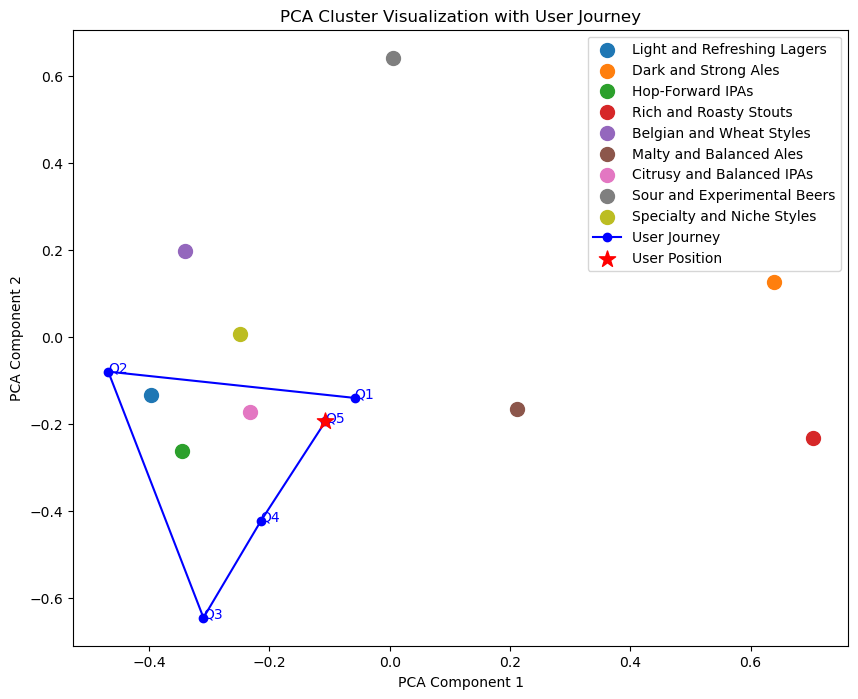

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# Simulated cluster means and user answers
cluster_means_array = cluster_means.values
user_answers = np.array([1, -0.5, -1., -1, 1]) # example of answers for someone who likes lagers

user_answers_path = np.diag(user_answers)
for i in range(1, user_answers_path.shape[0]):
    for j in range(i):
        user_answers_path[i, j] = user_answers_path[j, j]

# Dictionary for cluster numbers and their names
cluster_names = {
    0: "Light and Refreshing Lagers",
    1: "Dark and Strong Ales",
    2: "Hop-Forward IPAs",
    3: "Rich and Roasty Stouts",
    4: "Belgian and Wheat Styles",
    5: "Malty and Balanced Ales",
    6: "Citrusy and Balanced IPAs",
    7: "Sour and Experimental Beers",
    8: "Specialty and Niche Styles"
}


#Normalize both
normalized_cluster_means = normalize(cluster_means, norm='l2', axis=1)
normalized_user_answers = normalize(user_answers.reshape(1,-1), norm='l2', axis=1)
normalized_user_answers_path = normalize(user_answers_path, norm='l2', axis=1)

# Apply PCA on the normalized cluster means
pca = PCA(n_components=2)
pca_cluster_means = pca.fit_transform(normalized_cluster_means)
pca_user_answers_path = pca.transform(normalized_user_answers_path)

# Transform user answers using the same PCA
pca_user_positions = pca.transform(normalized_user_answers)

# Plotting
plt.figure(figsize=(10, 8))

# Plot PCA result for clusters with explicit labeling
for idx, (x, y) in enumerate(pca_cluster_means):
    plt.scatter(x, y, label=cluster_names[idx], s=100, cmap='tab10')


# Plot user journey
plt.plot(
    pca_user_answers_path[:, 0],
    pca_user_answers_path[:, 1],
    marker='o',
    color='blue',
    label='User Journey'
)

# Annotate user journey points
for i, (x, y) in enumerate(pca_user_answers_path):
    plt.text(x, y, f'Q{i+1}', fontsize=10, color='blue')


# Plot the user answers on the same plot
plt.scatter(
    pca_user_positions[0, 0],
    pca_user_positions[0, 1],
    color='red',
    s=150,
    label="User Position",
    marker='*',
    zorder=5
)

# Labels and legend
plt.title("PCA Cluster Visualization with User Journey")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [108]:
# method to get the nearest cluster to the user position
def get_nearest_cluster(user_position, cluster_means):
    distances = np.linalg.norm(cluster_means - user_position, axis=1)
    nearest_cluster = np.argmin(distances)
    print(f"Nearest cluster to user position: {cluster_names[nearest_cluster]}")
    return nearest_cluster

# Get the nearest cluster to the user position
nearest_cluster = get_nearest_cluster(user_answers, cluster_means_array) # this definitely makes sense when looking at the plot

Nearest cluster to user position: Hop-Forward IPAs


Testing: if a user would like to see and check for himself if the cluster recommender works he can try to answer the questions on his own (from -1 to 1). But just in case, we have an approximation of what each user answer would be if his preferences were the ones of a certain cluster.

In [ ]:
user_answers = np.array([0.5, -1., 0., 0., -1.])  # Light and Refreshing Lagers: Prefers light, crisp, balanced beers with no strong flavors.
nearest_cluster = get_nearest_cluster(user_answers, cluster_means_array)

user_answers = np.array([0.5, 0.5, 0., 0., 0.5])  # Dark and Strong Ales: Prefers rich, dark beers with bold, roasted flavors and slight hop-forward notes.
nearest_cluster = get_nearest_cluster(user_answers, cluster_means_array)

user_answers = np.array([1, -0.5, -1., -0.5, -1.])  # Hop-Forward IPAs: Strong preference for hop-forward beers with pine and citrus notes; dislikes dark beers.
nearest_cluster = get_nearest_cluster(user_answers, cluster_means_array)

user_answers = np.array([1., 1., -0.1, 1., -0.2])  # Rich and Roasty Stouts: Prefers complex, dark beers with coffee and chocolate flavors.
nearest_cluster = get_nearest_cluster(user_answers, cluster_means_array)

user_answers = np.array([1., -0.5, 1., -0.5, -0.5])  # Belgian and Wheat Styles: Likes dark beers with some fruity and yeast-forward notes, avoiding hop-forward flavors.
nearest_cluster = get_nearest_cluster(user_answers, cluster_means_array)

user_answers = np.array([1, 0.5, 0., 0., 0.5])  # Malty and Balanced Ales: Prefers beers with malt-forward, balanced flavors; neutral on hops and sweetness.
nearest_cluster = get_nearest_cluster(user_answers, cluster_means_array)

user_answers = np.array([0.5, -0.5, 0.5, -0.5, 0.5])  # Citrusy and Balanced IPAs: Enjoys hop-forward, citrusy beers with slight malty and fruity notes.
nearest_cluster = get_nearest_cluster(user_answers, cluster_means_array)

user_answers = np.array([-0.5, -0.5, 1., -0.5, 1.])  # Sour and Experimental Beers: Strong preference for tart, fruity beers with experimental flavors; dislikes hop-forward or roasted beers.
nearest_cluster = get_nearest_cluster(user_answers, cluster_means_array)

user_answers = np.array([0., 0.5, 0.5, 0., 0.])  # Specialty and Niche Styles: Neutral preference for complex, unique beers with a balance of hops and malt.
nearest_cluster = get_nearest_cluster(user_answers, cluster_means_array)

Nearest cluster to user position: Light and Refreshing Lagers
Nearest cluster to user position: Dark and Strong Ales
Nearest cluster to user position: Hop-Forward IPAs
Nearest cluster to user position: Rich and Roasty Stouts
Nearest cluster to user position: Belgian and Wheat Styles
Nearest cluster to user position: Dark and Strong Ales
Nearest cluster to user position: Sour and Experimental Beers
Nearest cluster to user position: Sour and Experimental Beers
Nearest cluster to user position: Dark and Strong Ales
